In [0]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

In [0]:
key_pts_frame = pd.read_csv('/data/training_frames_keypoints.csv')

n = 0
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n, 1:].values
key_pts = key_pts.astype('float').reshape(-1, 2)

print('Image name: ', image_name)
print('Landmarks shape: ', key_pts.shape)
print('First 4 key pts: {}'.format(key_pts[:4]))

Image name:  Luis_Fonsi_21.jpg
Landmarks shape:  (68, 2)
First 4 key pts: [[  45.   98.]
 [  47.  106.]
 [  49.  110.]
 [  53.  119.]]


In [0]:
print('Number of images: ', key_pts_frame.shape[0])

Number of images:  3462


In [0]:
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')


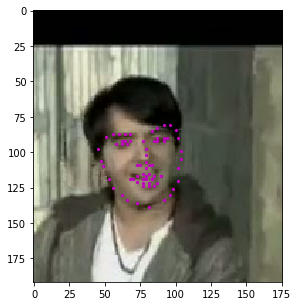

In [0]:

n = 0
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n, 1:].values
key_pts = key_pts.astype('float').reshape(-1, 2)

plt.figure(figsize=(5, 5))
show_keypoints(mpimg.imread(os.path.join('/data/training/', image_name)), key_pts)
plt.show()

In [0]:
from torch.utils.data import Dataset, DataLoader

class FacialKeypointsDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        
        self.key_pts_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.key_pts_frame)

    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir,
                                self.key_pts_frame.iloc[idx, 0])
        
        image = mpimg.imread(image_name)
        
        # if image has an alpha color channel, get rid of it
        if(image.shape[2] == 4):
            image = image[:,:,0:3]
        
        key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
        key_pts = key_pts.astype('float').reshape(-1, 2)
        sample = {'image': image, 'keypoints': key_pts}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [0]:
face_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                      root_dir='/data/training/')

print('Length of dataset: ', len(face_dataset))

Length of dataset:  3462


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


0 (236, 206, 3) (68, 2)
1 (175, 142, 3) (68, 2)
2 (109, 94, 3) (68, 2)


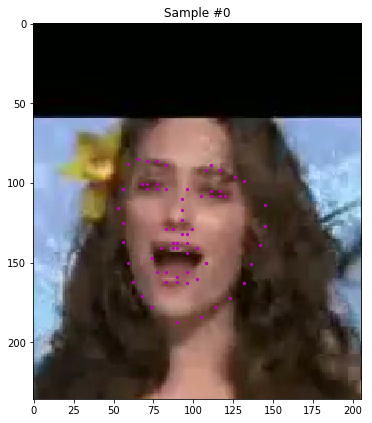

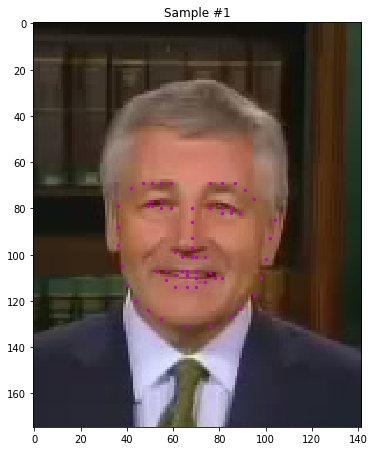

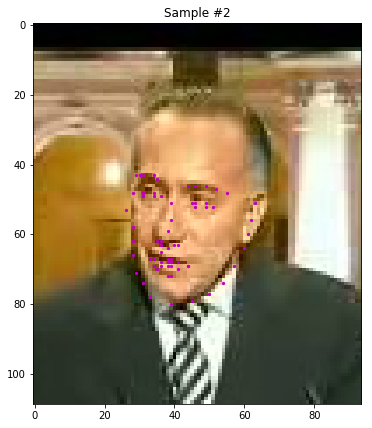

In [0]:
num_to_display = 3

for i in range(num_to_display):
    
    fig = plt.figure(figsize=(20,10))
    rand_i = np.random.randint(0, len(face_dataset))
    sample = face_dataset[rand_i]
    print(i, sample['image'].shape, sample['keypoints'].shape)

    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title('Sample #{}'.format(i))
    show_keypoints(sample['image'], sample['keypoints'])


In [0]:
import torch
from torchvision import transforms, utils
# tranforms

class Normalize(object):

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        image_copy=  image_copy/255.0
        
        key_pts_copy = (key_pts_copy - 100)/50.0


        return {'image': image_copy, 'keypoints': key_pts_copy}


class Rescale(object):

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))
        
        # scale the pts, too
        key_pts = key_pts * [new_w / w, new_h / h]

        return {'image': img, 'keypoints': key_pts}


class RandomCrop(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        key_pts = key_pts - [left, top]

        return {'image': image, 'keypoints': key_pts}


class ToTensor(object):

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
         
        if(len(image.shape) == 2):
            image = image.reshape(image.shape[0], image.shape[1], 1)

        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(key_pts)}

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


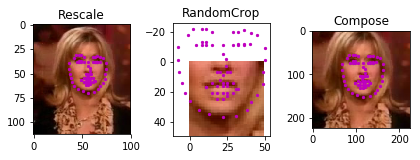

In [0]:
rescale = Rescale(100)
crop = RandomCrop(50)
composed = transforms.Compose([Rescale(250),
                               RandomCrop(224)])

test_num = 500
sample = face_dataset[test_num]

fig = plt.figure()
for i, tx in enumerate([rescale, crop, composed]):
    transformed_sample = tx(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tx).__name__)
    show_keypoints(transformed_sample['image'], transformed_sample['keypoints'])

plt.show()

In [0]:
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


In [0]:
print('Number of images: ', len(transformed_dataset))

for i in range(5):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())


Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])
4 torch.Size([1, 224, 224]) torch.Size([68, 2])


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
